In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("..")

In [3]:
%load_ext autoreload
%autoreload 2
import penzai
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import jax_smi
jax_smi.initialise_tracking()

In [5]:
filename = "models/phi-3-16.gguf"
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained(filename, device_map="auto")

In [6]:
from micrlhf.utils.vector_storage import download_vector
layer = 20

In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
tokenizer.padding_side = "right"

In [8]:
from micrlhf.utils.mmlu_eval import MMLUEval
mmlu_eval = MMLUEval()

In [19]:
resids = mmlu_eval.get_resids(llama, tokenizer, layer)

  0%|          | 0/4422 [00:00<?, ?it/s]

  0%|          | 0/1474 [00:00<?, ?it/s]

In [32]:
vector_name = "phi3-sycophancy-l20-recon-r5"
vector = download_vector(vector_name, overwrite=True)

In [33]:
x = [[], []]
for vec, correct in resids:
    x[correct].append(float(vec @ vector))

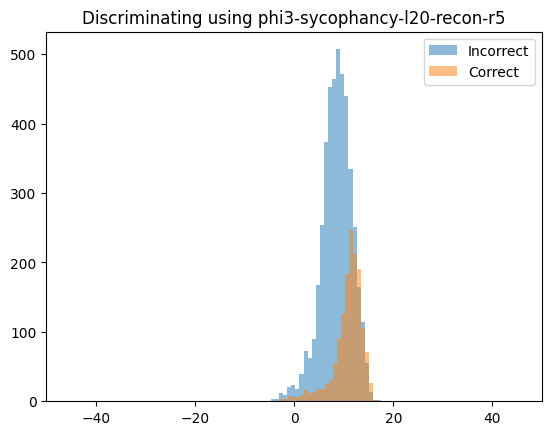

In [34]:
from matplotlib import pyplot as plt
plt.title(f"Discriminating using {vector_name}")
plt.xlim(-50, 50)
plt.hist(x[0], bins=500, alpha=0.5, label="Incorrect")
plt.hist(x[1], bins=500, alpha=0.5, label="Correct")
plt.legend()
plt.show()